In [ ]:
# This code is for retrospective high b-value DWI denoising using DnCNN
# Code dependency Python 3.7, Tesnsorflow and Keras
# Reference article: https://ieeexplore.ieee.org/abstract/document/7839189

!pip install bm3d
!pip install pydicom
!pip install medpy

# Python modules
import os
import cv2
import logging
import time 
import glob
import os.path
import models
import bm3d
import pydicom
import nibabel as nib
import numpy as np
import pandas as pd
import scipy
from scipy import stats 
from scipy.stats import rice
from scipy import ndimage
#from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
import imquality.brisque as brisque
import skimage.measure    
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from keras.models import load_model
from keras.optimizers import Adam
from skimage.measure import compare_psnr, compare_ssim
from skimage.metrics import structural_similarity as ssim
from medpy.filter.smoothing import anisotropic_diffusion   
from skimage import data
from math import log10, sqrt
from skimage.filters import unsharp_mask
from skimage import filters
from skimage import restoration
from skimage.filters import threshold_otsu, threshold_local,threshold_mean,threshold_yen,threshold_li



In [ ]:
# Parameters
class Args:
      model='DnCNN'
      batch_size=128
      train_data='../retrospective_study/data/npy_data/clean_patches_a.npy' # Clean patches for training # X_train ,for old prospective data
      test_dir='../retrospective_study/testing_data/'
      sigma=0.01 # Rician noise level 0.01,0.03,0.05
      epoch=60
      lr=1e-3
      save_every=10
      pretrain=None
      only_test=False
args=Args()

#PSNR
def PSNR(original, denoised,mask):
    original_mask=mask*denoised
    denoised_mask=mask*denoised
    mse = np.mean((original_mask - denoised_mask) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 0
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [ ]:
# This section is to save information log after every 5 epochs in snapshot directory
if not args.only_test:
    save_dir = './snapshot/save_'+ args.model + '_' + 'sigma' + str(args.sigma) + '_' + time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime()) + '/'
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    # log
    logging.basicConfig(level=logging.INFO,format='%(asctime)s %(filename)s[line:%(lineno)d] %(levelname)s %(message)s',
                    datefmt='%Y %H:%M:%S',
                    filename=save_dir+'info.log',
                    filemode='w')
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    formatter = logging.Formatter('%(name)-6s: %(levelname)-6s %(message)s')
    console.setFormatter(formatter)
    logging.getLogger('').addHandler(console)
    
    logging.info(args)
    
else:
    save_dir = '/'.join(args.pretrain.split('/')[:-1]) + '/'

root  : INFO   <__main__.Args object at 0x7fb6e2a425d0>


In [ ]:
# Training 
# This is for b1000/b2000 DWI data
# Else dont run this cell
x_train = np.load(args.train_data)
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],x_train.shape[2],1))
x_train = x_train.astype('float32')
x_train = x_train/np.max(x_train)

In [ ]:
#This function is only to generate x_train and y_train 

def train_datagen(y_, batch_size=8):
    indices = list(range(y_.shape[0]))
    while(True):
        np.random.shuffle(indices)    # shuffle
        for i in range(0, len(indices), batch_size):
            ge_batch_y = y_[indices[i:i+batch_size]]
            ge_y=ge_batch_y[:,]
            noise = scipy.stats.rice.rvs(1,args.sigma,size=ge_batch_y.shape)*0.08
            ge_batch_x = ge_batch_y + noise  # input image = clean image + noise                         
            yield ge_batch_x, ge_batch_y  

In [ ]:

#step decay
def step_decay(epoch):
    initial_lr = args.lr
    if epoch<50:
        lr = initial_lr
    else:
        lr = initial_lr/10
    return lr

In [ ]:

# model selection
if args.pretrain:   model = load_model(args.pretrain, compile=False) # If it is pretrained model
else:   
    if args.model == 'DnCNN': model = models.DnCNN()

# compile the model
model.compile(optimizer='Adam',loss='mse')
#print(model.summary())
lr = LearningRateScheduler(step_decay)


In [ ]:

# train
# Execute this cell iff you are training the model 
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='loss', mode='min', min_delta=1e-3,patience=4)
ckpt = ModelCheckpoint(save_dir+'/model_{epoch:02d}.h5', monitor='loss', 
                    verbose=0, period=args.save_every,save_weights_only=True,
     mode='min',
    save_best_only=True)
csv_logger = CSVLogger(save_dir+'/log.csv', append=True, separator=',')

lr = LearningRateScheduler(step_decay)
    # train 
start = time.time()
history = model.fit(train_datagen(x_train, batch_size=args.batch_size),steps_per_epoch=len(x_train)//args.batch_size, 
                    epochs=args.epoch, verbose=1, callbacks=[es])
stop = time.time()
print(f"Training time: {stop - start}s")
model.save('../retrospective_study/saved_models/model_0.03_final1/')

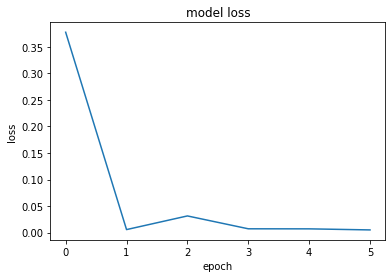

In [ ]:
%matplotlib inline
train_loss=history.history['loss']
plt.plot(train_loss)
   
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
#loaded_model = tf.keras.models.load_model('../retrospective_study/saved_models/model_0.01_final1/')
#loaded_model = tf.keras.models.load_model('../retrospective_study/saved_models/model_0.03_final1/')
loaded_model = tf.keras.models.load_model('../retrospective_study/saved_models/model_0.05_final1/')
model= loaded_model

In [ ]:
#Retrospective DWI denoising
# Testing 
    
import sklearn.metrics as metrics
import scipy
from scipy.stats import rice
import matplotlib.pyplot as plt
#import pybm3d
print('Start to test on {}'.format(args.test_dir))
out_dir = save_dir + args.test_dir.split('/')[-1] + '/'
if not os.path.exists(out_dir):
       os.mkdir(out_dir)
im_data=[]    
im=[]    
name = []
psnr = []
ssim = []
entropy_dn=[]
psnr_n = []
ssim_n = []
entropy_n=[]
psnr_bm=[]
psnr_bl=[]
psnr_ad=[]
psnr_tv=[]
ssim_bm=[]
ssim_bl=[]
ssim_ad=[]
ssim_tv=[]
entropy_bl=[]
entropy_bm=[]
entropy_ad=[]
entropy_tv=[]
count=0
sigma_val=[0,01,0,03,0.05]

#Reading 120 slices from three healthy controls for testing
for dirpath, dirnames, filenames in os.walk('/retrospective_study/testing_data/'):
  for filename in [f for f in filenames if f.endswith(".nii.gz")]:
      print(os.path.join(dirpath, filename)) 
      img_path=os.path.join(dirpath, filename)
      img = nib.load(os.path.join(dirpath, filename))
      x_test_nifti = np.array(img.get_data())          
      #print(x_test_nifti.shape)
      im_data.append(x_test_nifti)        
      slice_total=x_test_nifti.shape[2]
      dir_total=x_test_nifti.shape[3]        
      for num_slice in range(0,slice_total-35):
        for num_dir in range(dir_total-4,dir_total-1):
           x_test_clean=x_test_nifti[:,:,num_dir,num_slice]
           if np.sum(x_test_clean)>0:
              x_test_clean =x_test_clean.astype('float32')
             
          # read image
              x_test_clean=cv2.resize(x_test_clean,(128,128))
              x_test_clean=x_test_clean/np.max(x_test_clean)
             
             
          # Add noise
              for s in sigma_val:    
                  noise=scipy.stats.rice.rvs(1,s,size=(x_test_clean.shape))*0.08
                  x_test_noisy=x_test_clean + noise
                  
         # predict
                  x_test_inf = x_test_noisy.reshape(1, x_test_noisy.shape[0], x_test_noisy.shape[1], 1) 
                  y_predict = model.predict(x_test_inf)    
                  y_test = y_predict.reshape(x_test_clean.shape)                  
                  y_test=np.clip(y_test,0,1)
                  
                  # Sharpening            
                  un_msk=x_test_clean-y_test #unsharp masking for medium level contrast details
                  y_test=y_test+0.9*un_msk   # set weightage of 0.9
                   
      
                  # Comparative filters

                 # BM3D denoising
                  adaptive_thresh = threshold_local(x_test_noisy,75)
                  threshold =x_test_noisy > adaptive_thresh
                  bm3d_filtered = bm3d.bm3d(x_test_noisy,sigma_val, stage_arg=threshold)

                  # Total variation filter
                  tv_f = restoration.denoise_tv_chambolle(x_test_noisy, weight=0.05) # greater the weight more denoising # standard weight=0.1
                 
                  
                  # Bilateral filter
                  x_test_noisy=x_test_noisy.astype('float32')
                  bilateral = cv2.bilateralFilter(x_test_noisy,3, 8, 8) # diameter=3,sigmacolor=8,sigmaspace=8 # grayscale values
                                 
                  # Anisotropic diffusion denoising
                  ad_filtered = anisotropic_diffusion(x_test_noisy,niter=3,kappa=50,gamma=0.1,option=1) #niter  - number of iterations
	                                                                                                      #kappa  - conduction coefficient 20-100 ?
	                                                                                                      #gamma  - max value of .25 for stability	       
                                                                                                        #option - 1 Perona Malik diffusion equation No 1
                                                                                                                # 2 Perona Malik diffusion equation No 2
                  
                  # Quality metrics PSNR,SSIM,Entropy  
                  #PSNR      
                  psnr_noise, psnr_denoised = compare_psnr(x_test_clean, x_test_noisy,data_range=1), compare_psnr(x_test_clean, y_test,data_range=1)  
                  psnr_bm3d, psnr_ad1 = compare_psnr(x_test_noisy, bm3d_filtered,data_range=1),compare_psnr(x_test_noisy, ad_filtered,data_range=1)
                  psnr_tv1,psnr_bil = compare_psnr(x_test_clean,tv_f,data_range=1), compare_psnr(x_test_clean,bilateral,data_range=1)              
                   
                  #SSIM                
                  ssim_noise, ssim_denoised= compare_ssim(x_test_clean, x_test_noisy), compare_ssim(x_test_clean, y_test)
                  ssim_bm3d= compare_ssim(x_test_clean, bm3d_filtered,data_range=np.max(x_test_clean))
                  ssim_ad1=compare_ssim(x_test_clean, ad_filtered,data_range=np.max(x_test_clean))
                  ssim_tv1 =compare_ssim(x_test_clean,tv_f )
                  ssim_bil=compare_ssim(x_test_clean,bilateral)
                              
                  # Entropy
                  entropy_noisy = skimage.measure.shannon_entropy(x_test_noisy)
                  entropy_denoise = skimage.measure.shannon_entropy(y_test) 
                  entropy_bm3d = skimage.measure.shannon_entropy(bm3d_filtered)
                  entropy_tvf = skimage.measure.shannon_entropy(tv_f)
                  entropy_ad1= skimage.measure.shannon_entropy(ad_filtered)
                  entropy_bil = skimage.measure.shannon_entropy(bilateral)                                    
                            
                  psnr.append(psnr_denoised)
                  ssim.append(ssim_denoised)
                  entropy_dn.append(entropy_denoise)
                  psnr_n.append(psnr_noise)
                  ssim_n.append(ssim_noise)
                  entropy_n.append(entropy_noisy)
                  psnr_bl.append(psnr_bil)
                  ssim_bl.append(ssim_bil)
                  entropy_bl.append(entropy_bil)
                  psnr_bm.append(psnr_bm3d)
                  ssim_bm.append(ssim_bm3d)
                  entropy_bm.append(entropy_bm3d)
                  psnr_ad.append(psnr_ad1)
                  ssim_ad.append(ssim_ad1)
                  entropy_ad.append(entropy_ad1)
                  psnr_tv.append(psnr_tv1)
                  ssim_tv.append(ssim_tv1)
                  entropy_tv.append(entropy_tvf)

                  # Save quantitative results in output directory        
                  
                 pd.DataFrame({
                               'entropy_denoised':np.array(entropy_dn),'psnr_noisy':np.array(psnr_n), 'ssim_noisy':np.array(ssim_n),'entropy_noisy':np.array(entropy_n),
                                'psnr_bilateral':np.array(psnr_bl), 'ssim_bilateral':np.array(ssim_bl),'entropy_bilateral':np.array(entropy_bl),
                                'psnr_bm3d':np.array(psnr_bm), 'ssim_bm3d':np.array(ssim_bm),'entropy_bm3d':np.array(entropy_bm),
                                'psnr_anisotropic':np.array(psnr_ad), 'ssim_anisotropic':np.array(ssim_ad),'entropy_anisotropic':np.array(entropy_ad),
                                'psnr_totalvariation':np.array(psnr_tv), 'ssim_totalvariation':np.array(ssim_tv),'entropy_totalvariation':np.array(entropy_tv)}).to_csv(out_dir+'/metrics_0.05_final_a5.csv', index=True)
                    

        


Start to test on ../DnCNN-keras-master/data/Test/
/content/gdrive/My Drive/DnCNN-keras-master/DnCNN-keras-master/data/Test/test_retrospective/sub-TCRc007_ses-1_acq-preSMS_dwi.nii.gz


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/usr/local/lib/python3.7/dist-packages/medpy/filter/smoothing.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  deltas[i][slicer] = numpy.diff(out, axis=i)
/usr/local/lib/python3.7/dist-packages/medpy/filter/smoothing.py:164: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpret

/content/gdrive/My Drive/DnCNN-keras-master/DnCNN-keras-master/data/Test/test_retrospective/sub-TCRc008_ses-1_acq-preSMS_dwi.nii.gz
/content/gdrive/My Drive/DnCNN-keras-master/DnCNN-keras-master/data/Test/test_retrospective/sub-TCRc010_ses-1_acq-preSMS_dwi.nii.gz
